## Question 3: Natural Language Processing

In [1]:
corpuses = [
"nlp/01-introduction.csv",
"nlp/02-data-exploration.csv",
"nlp/03-decision-trees.csv",
"nlp/04-regression.csv",
"nlp/05-support-vector-machines.csv",
"nlp/06-neural-networks-1.csv",
"nlp/07-neural-networks-2.csv",
"nlp/08-evaluation.csv",
"nlp/09-clustering.csv",
"nlp/10-frequent-itemsets.csv",
]

In [2]:
# Load the dataset
import pandas as pd


### a)

(1793, 4)
Index(['start', 'end', 'text', 'lecture'], dtype='object')


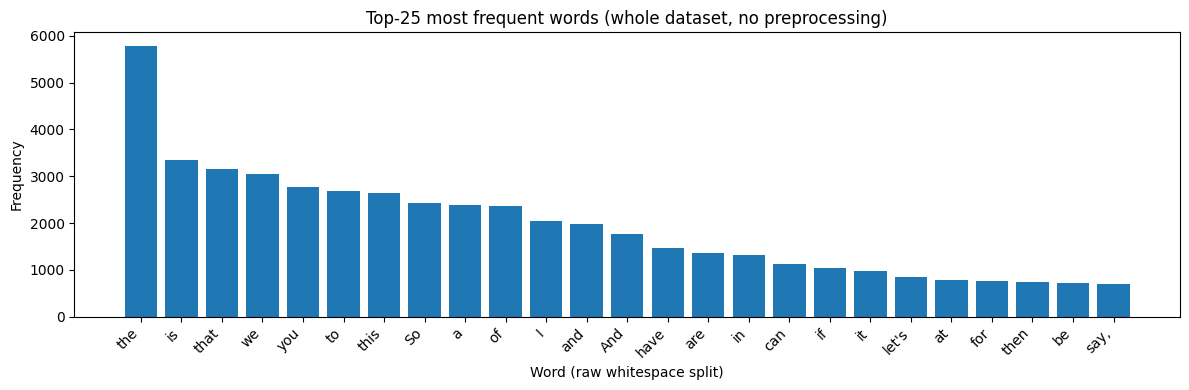

In [4]:
from collections import Counter
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

dfs = []
for path in corpuses:
    lecture_name = path.split("/")[-1].replace(".csv", "")  # e.g., 01-introduction
    tmp = pd.read_csv(path)
    tmp["lecture"] = lecture_name                            # 关键：加 lecture 列
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)
print(df.columns)

# 2) Collect "words" by raw whitespace split (NO preprocessing)
words = []
for text in df["text"]:
    w = [word for word in str(text).split()]   # 和练习题一样：先做list，再extend
    words.extend(w)

# 3) Frequency + top-25
fdist = FreqDist(words)
top25 = fdist.most_common(25)

# 4) Plot histogram (bar chart)
labels = [w for w, c in top25]
counts = [c for w, c in top25]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.xlabel("Word (raw whitespace split)")
plt.ylabel("Frequency")
plt.title("Top-25 most frequent words (whole dataset, no preprocessing)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### b)

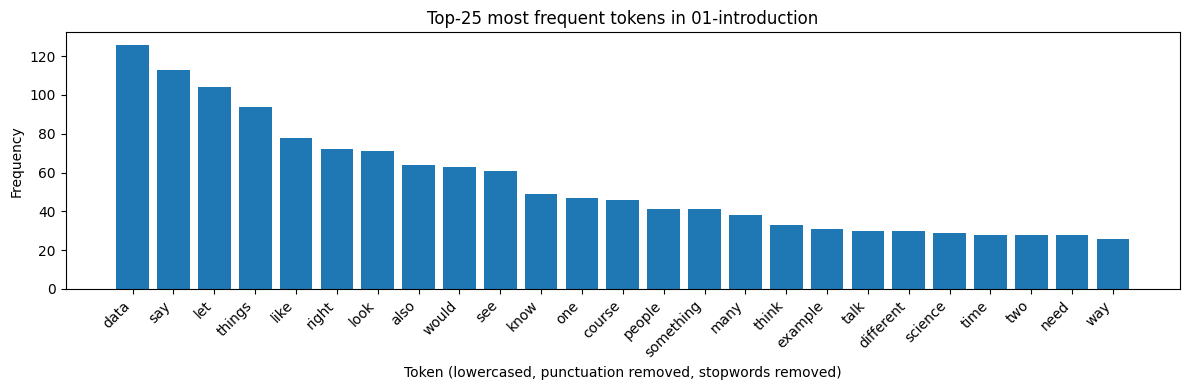

In [6]:
import string
import nltk, re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

nltk.download("punkt_tab")
nltk.download("stopwords")

stop_list = stopwords.words("english")

def preprocess_text(s):
    # 1) lowercase + 2) punkt_tab tokenizer (word_tokenize) + 3) remove punctuation + 4) remove stopwords
    tokens = word_tokenize(str(s).lower())
    tokens = [t for t in tokens if re.fullmatch(r"\w+", t)]           # 去掉标点/符号 token
    tokens = [t for t in tokens if t not in stop_list]                # 去停用词
    return tokens

# add column tokenized_text
df["tokenized_text"] = df["text"].apply(preprocess_text)

# histogram: top-25 tokens in 01-introduction
words_intro = []
for toks in df.loc[df["lecture"] == "01-introduction", "tokenized_text"]:
    words_intro.extend(toks)

top25 = FreqDist(words_intro).most_common(25)
labels = [w for w, c in top25]
counts = [c for w, c in top25]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.xlabel("Token (lowercased, punctuation removed, stopwords removed)")
plt.ylabel("Frequency")
plt.title("Top-25 most frequent tokens in 01-introduction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### c)

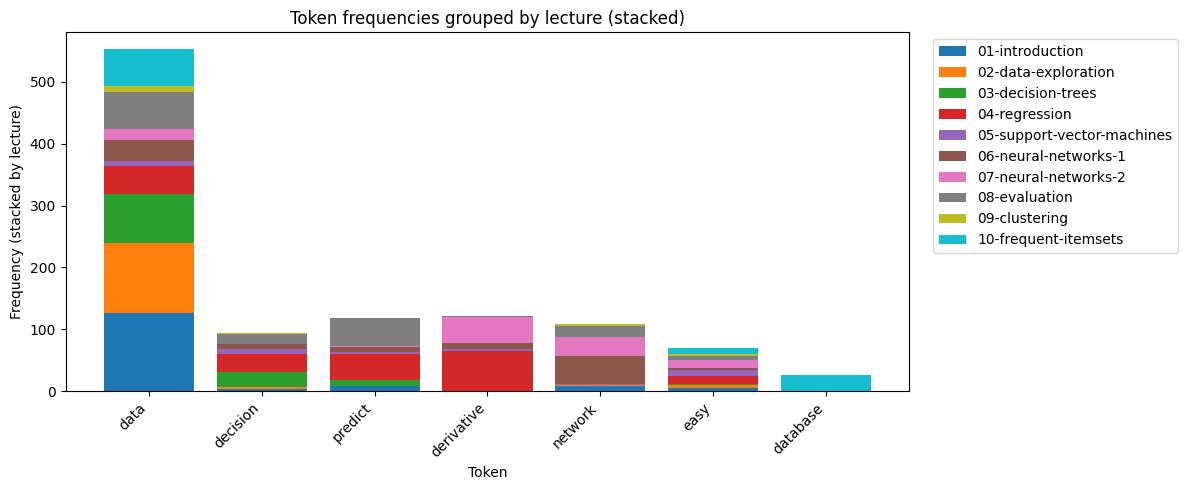

In [8]:
import numpy as np
tokens = ["data", "decision", "predict", "derivative", "network", "easy", "database"]
lectures = sorted(df["lecture"].unique())

# 1) 统计每个 lecture 中这些 token 的频次（练习题风格：先攒words，再FreqDist）
counts = {lec: [] for lec in lectures}
for lec in lectures:
    words = []
    for toks in df.loc[df["lecture"] == lec, "tokenized_text"]:
        words.extend(toks)
    fdist = FreqDist(words)
    counts[lec] = [fdist[t] for t in tokens]

# 2) 画 stacked bar：x=token，堆叠=lecture
bottom = np.zeros(len(tokens))
x = np.arange(len(tokens))

plt.figure(figsize=(12, 5))
for lec in lectures:
    plt.bar(x, counts[lec], bottom=bottom, label=lec)
    bottom += np.array(counts[lec])

plt.xticks(x, tokens, rotation=45, ha="right")
plt.xlabel("Token")
plt.ylabel("Frequency (stacked by lecture)")
plt.title("Token frequencies grouped by lecture (stacked)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### d)

In [10]:
from nltk.util import ngrams
from nltk.probability import ConditionalFreqDist
import random


# ========== 1) 为语言模型准备 token（不去 stopwords，更符合“讲课风格”） ==========
def preprocess_for_lm(s):
    toks = word_tokenize(str(s).lower())
    toks = [t for t in toks if re.fullmatch(r"\w+", t)]  # 去掉标点/符号 token
    return toks

df["tokenized_text_lm"] = df["text"].apply(preprocess_for_lm)

# ========== 2) 构造 ConditionalFreqDist：P(next | context) ==========
def build_cfd(tokenized_segments, n):
    """
    tokenized_segments: iterable of token lists (each lecture segment separately)
    n: n-gram order
    """
    cfd = ConditionalFreqDist()
    for seg in tokenized_segments:
        seg = list(seg)
        padded = ["<s>"] * (n - 1) + seg + ["</s>"]
        for i in range(len(padded) - n + 1):
            ngram = padded[i : i + n]
            context = tuple(ngram[:-1])
            nxt = ngram[-1]
            cfd[context][nxt] += 1
    return cfd

# ========== 3) 预测下一个词（按题目：每次 choices 前都 seed；候选词先 sorted） ==========
def predict_next(cfd, context):
    """
    context: tuple of length n-1
    return: next token or None (if unseen)
    """
    if context not in cfd:
        return None

    possible = sorted(cfd[context].keys())  # 题目要求字典序排序
    weights = [cfd[context][w] for w in possible]

    random.seed(32133)  # 题目要求：每次采样前都 seed
    return random.choices(possible, weights=weights, k=1)[0]

# ========== 4) 给定 seed text 生成序列 ==========
def generate_text(seed_text, n, max_new_tokens=30):
    # 对 seed 做同样的 preprocessing
    seed_tokens = preprocess_for_lm(seed_text)

    cfd = build_cfd(df["tokenized_text_lm"], n)

    # 若 seed 不足 n-1，左侧用 <s> padding（题目要求）
    context_tokens = (["<s>"] * max(0, (n - 1 - len(seed_tokens)))) + seed_tokens
    generated = []

    for _ in range(max_new_tokens):
        context = tuple(context_tokens[-(n - 1):])
        nxt = predict_next(cfd, context)

        # unseen context -> stop
        if nxt is None:
            break
        # predicted end -> stop
        if nxt == "</s>":
            break

        generated.append(nxt)
        context_tokens.append(nxt)

    return seed_tokens + generated

# ========== 5) 按题目生成：seed="introduction to data"，n ∈ {3,4,5,16} ==========
seed = "introduction to data"
for n in [3, 4, 5, 16]:
    out = generate_text(seed, n, max_new_tokens=30)
    print(f"n={n} (len={len(out)}):")
    print(" ".join(out))
    print()


n=3 (len=33):
introduction to data science machine learning or the other ones so this is perfectly fitting so my error is minimized there so the one that looks like this now the node that is

n=4 (len=33):
introduction to data science so this lecture will be a group assignment while you are taking this course that you understand there is precisely one that has all kinds of other things that

n=5 (len=3):
introduction to data

n=16 (len=3):
introduction to data



### e)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer

stop_set = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

# 1) 基础token（只做 lowercase + 去标点 + tokenization；不在这里去停用词/不stem）
def preprocess_basic(s):
    toks = word_tokenize(str(s).lower())
    toks = [t for t in toks if re.fullmatch(r"\w+", t)]  # remove punctuation tokens
    return toks

# 为了严格符合(e)，单独准备一列给TF-IDF用
df["tokenized_text_e"] = df["text"].apply(preprocess_basic)

# 2) 给 TfidfVectorizer 的自定义 analyzer：stopword removal + stemming
#    这里输入是“空格分隔的token字符串”，所以 analyzer 就 split -> filter -> stem
def my_analyzer(doc: str):
    toks = doc.split()
    toks = [t for t in toks if t not in stop_set]
    toks = [stemmer.stem(t) for t in toks]
    return toks

def hierarchical_retrieve(query: str, k=2, m=2):
    # ========= Level 1: lecture retrieval =========
    lectures = sorted(df["lecture"].unique())

    lecture_docs = []
    for lec in lectures:
        # one document per lecture: concatenate tokens from all its segments
        all_toks = []
        for seg_toks in df.loc[df["lecture"] == lec, "tokenized_text_e"]:
            all_toks.extend(seg_toks)
        lecture_docs.append(" ".join(all_toks))

    vec1 = TfidfVectorizer(analyzer=my_analyzer)
    X_lec = vec1.fit_transform(lecture_docs)

    q_doc = " ".join(preprocess_basic(query))
    q_vec = vec1.transform([q_doc])

    # cosine sim = dot because TF-IDF is L2-normalized by default
    lec_scores = (X_lec.dot(q_vec.T)).toarray().ravel()
    top_lec_idx = np.argsort(-lec_scores)[:k]

    results = []
    for idx in top_lec_idx:
        lec = lectures[idx]
        lec_score = float(lec_scores[idx])

        # ========= Level 2: timestamp retrieval within lecture =========
        seg_df = df.loc[df["lecture"] == lec, ["start", "end", "tokenized_text_e", "text"]].reset_index(drop=True)

        seg_docs = [" ".join(toks) for toks in seg_df["tokenized_text_e"]]

        vec2 = TfidfVectorizer(analyzer=my_analyzer)
        X_seg = vec2.fit_transform(seg_docs)
        q_vec2 = vec2.transform([q_doc])

        seg_scores = (X_seg.dot(q_vec2.T)).toarray().ravel()
        top_seg_idx = np.argsort(-seg_scores)[:m]

        timestamps = []
        for j in top_seg_idx:
            timestamps.append({
                "start": float(seg_df.loc[j, "start"]),
                "end": float(seg_df.loc[j, "end"]),
                "score": float(seg_scores[j]),
                "text": seg_df.loc[j, "text"]
            })

        results.append({
            "lecture": lec,
            "lecture_score": lec_score,
            "timestamps": timestamps
        })

    return results

# ====== 按题目要求跑两条 query：k=2, m=2 ======
for q in ["gradient descent approach", "beer and diapers"]:
    res = hierarchical_retrieve(q, k=2, m=2)
    print(f"\nQuery: {q}")
    for r in res:
        print(f"- Lecture: {r['lecture']} | score={r['lecture_score']:.4f}")
        for t in r["timestamps"]:
            print(f"  - [{t['start']:.2f}, {t['end']:.2f}] seg_score={t['score']:.4f} | {t['text'][:120]}...")



Query: gradient descent approach
- Lecture: 04-regression | score=0.0762
  - [3324.14, 3353.17] seg_score=0.2939 | steep curve, which kind of, okay, here we predict an error, and here we predict good, but in between, the decision bound...
  - [4149.38, 4177.49] seg_score=0.2903 | train the well-performing model, which nicely describes the data using the approach we just saw. So we do not want to ch...
- Lecture: 06-neural-networks-1 | score=0.0304
  - [2272.58, 2301.78] seg_score=0.4594 | of the sigmoid function, the derivative of this is, let's say, sigmoid x times 1 minus sigmoid x. You have no clue why t...
  - [1921.86, 1952.67] seg_score=0.3124 | So you know how to update the weights. And that is, let's say, the gradient descent at a much larger scale than things t...

Query: beer and diapers
- Lecture: 10-frequent-itemsets | score=0.0290
  - [1521.46, 1549.01] seg_score=0.4175 | that if I want to add one more item, the frequency will always go down. You need to realize if I look